# 빅데이터 분석기사 실기 독학

## dataq.or.kr에서 제공한 문제 샘플 및 데이터 샘플 활용


### 1. 작업형 제1유형 : 데이터 처리 영역

- mtcars 데이터셋의 qsec 컬럼을 최소최대 척도(Min Max Scale)로 변환한 후 0.5 보다 큰 값을 가지는 레코드 수를 구하시오.

In [37]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

In [2]:
mtc = pd.read_csv("mtcars.csv")

In [3]:
mtc.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [4]:
target = mtc[['qsec']]

### <center>MinMaxScaling<center>

$$ \frac{x - MIN(x)}{MAX(x) - MIN(x)} $$

#### 1) sklearn minmaxscaler 사용

In [5]:
scaler = MinMaxScaler()

In [6]:
mtc['scaled_qsec'] = scaler.fit_transform(target)

In [7]:
mtc.scaled_qsec[mtc.scaled_qsec > 0.5] # 0.5 보다 큰 값들 추출

3     0.588095
5     0.680952
7     0.654762
8     1.000000
10    0.523810
17    0.591667
19    0.642857
20    0.655952
25    0.523810
Name: scaled_qsec, dtype: float64

In [8]:
mtc.qsec[mtc.scaled_qsec > 0.5].shape[0]

9

#### 2) 직접 구현

In [9]:
scaled_qsec = (mtc.qsec - mtc.qsec.min()) / (mtc.qsec.max() - mtc.qsec.min())

In [10]:
mtc.scaled_qsec[scaled_qsec > .5] # 0.5 보다 큰 값

3     0.588095
5     0.680952
7     0.654762
8     1.000000
10    0.523810
17    0.591667
19    0.642857
20    0.655952
25    0.523810
Name: scaled_qsec, dtype: float64

In [11]:
mtc.qsec[scaled_qsec > .5].shape[0]

9

### 2. 작업형 제2유형 : 모형 구축 및 평가 영역
- 고객 3,500명에 대한 학습용 데이터(y_train.csv, X_train.csv)를 이용하여 성별예측 모형을 만든 후, 이를 평가용 데이터(X_test.csv)에 적용하여 얻은 2,482명 고객의 성별 예측값(남자일 확률)을 다음과 같은 형식의 CSV 파일로 생성하시오.(제출한 모델의 성능은 ROC-AUC 평가지표에 따라 채점)

<font color = 'red'><유의사항>
    
    
성능이 우수한 예측모형을 구축하기 위해서는 적절한 데이터 전처리, Feature Engineering, 분류 알고리즘 사용, 초매개변수 최적화, 모형 앙상블 등이 수반되어야 한다.

In [12]:
X_train = pd.read_csv("X_train.csv", encoding = 'cp949')
test = pd.read_csv("X_test.csv", encoding = 'cp949')
y_train = pd.read_csv('y_train.csv', encoding = 'cp949')

#### 최종 파일 제출을 위해 별도로 test파일의 cust_id행 저장
custid = test.cust_id

In [13]:
X_train.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85


In [14]:
test.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,3500,70900400,22000000,4050000.0,골프,부산본점,13,1.461538,0.789474,26
1,3501,310533100,38558000,48034700.0,농산물,잠실점,90,2.433333,0.369863,3
2,3502,305264140,14825000,30521000.0,가공식품,본 점,101,14.623762,0.083277,3
3,3503,7594080,5225000,NaN,주방용품,부산본점,5,2.000000,0.000000,47
4,3504,1795790,1411200,NaN,수산품,청량리점,3,2.666667,0.125000,8


In [15]:
y_train.head()

,cust_id,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


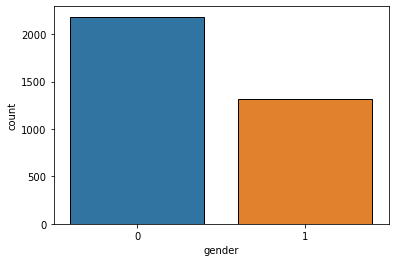

In [16]:
sns.countplot(y_train.gender, edgecolor = (0, 0, 0))
plt.show()

#### 1) 데이터 전처리

In [17]:
train = pd.merge(X_train, y_train)

- cust_id는 모델링에 필요하지 않으므로 삭제
- 환불금액은 결측치가 너무 많으므로 삭제

In [18]:
train.drop(['cust_id', '환불금액'], axis = 1, inplace = True)
test.drop(['cust_id', '환불금액'], axis = 1, inplace = True)

In [19]:
train.at[train[train.총구매액 < 0].index, '총구매액'] = 0
train.at[train[train.최대구매액 < 0].index, '최대구매액'] = 0

In [20]:
test.at[test[test.총구매액 < 0].index, '총구매액'] = 0
test.at[test[test.최대구매액 < 0].index, '최대구매액'] = 0

#### 2) Feature Engineering

In [21]:
train.groupby('gender').mean()

,총구매액,최대구매액,내점일수,내점당구매건수,주말방문비율,구매주기
gender,,,,,,
0,1.110067e+08,2.250431e+07,22.522894,2.900148,0.290695,20.162088
1,6.029865e+07,1.495320e+07,13.828267,2.726785,0.334714,22.279635


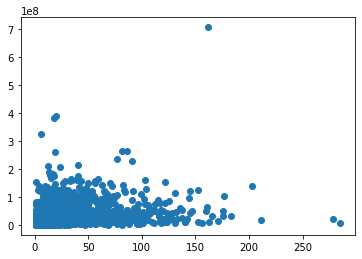

In [22]:
plt.scatter(train.내점일수, train.최대구매액)

최대구매액이 너무 크고 내점일수가 250 초과인 행 삭제

In [23]:
train[(train.최대구매액 > 6e8) | (train.내점일수 > 250)].index

Int64Index([21, 1541, 1626], dtype='int64')

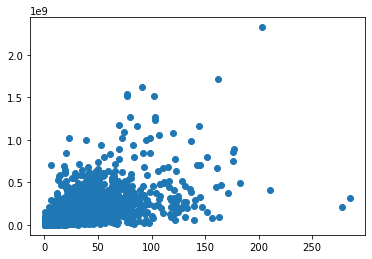

In [24]:
plt.scatter(train.내점일수, train.총구매액)

총구매액이 너무 높은 행 삭제

In [25]:
train[train.총구매액 > 2e9].index

Int64Index([2513], dtype='int64')

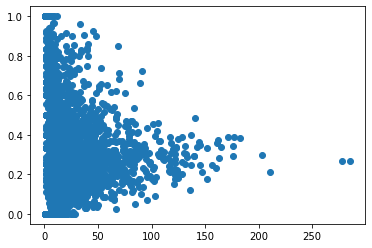

In [26]:
plt.scatter(train.내점일수, train.주말방문비율)

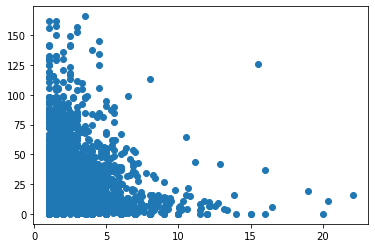

In [27]:
plt.scatter(train.내점당구매건수, train.구매주기)

In [28]:
train = train.query('index not in [2513, 21, 1541, 1626]')

파생변수 생성
- female_brand = 여성들이 주로 구매한 주구매상품으로부터 생성
- male_brand = 남성들이 주로 구매한 주구매상품으로부터 생성
- store = 여성들이 자주 이용한 주구매지점으로부터 생성

In [29]:
train['female_brand'] = [1 if x in ['시티웨어', '가구식품', '화장품', '모피/피혁', '디자이너', '농상물'] else 0 for x in train.주구매상품]
test['female_brand'] = [1 if x in ['시티웨어', '가구식품', '화장품', '모피/피혁', '디자이너', '농상물'] else 0 for x in test.주구매상품]

In [30]:
train['male_brand'] = [1 if x in ['주방가전', '주류', '남성 캐주얼', '셔츠', '남성정장', '주류'] else 0 for x in train.주구매상품]
test['male_brand'] = [1 if x in ['주방가전', '주류', '남성 캐주얼', '셔츠', '남성정장', '주류'] else 0 for x in test.주구매상품]

In [31]:
train['store'] = [1 if x in ['노원점', '부평점', '일산점', '부산본점', '본 점', '영등포점', '분당점', '잠실점', '강남점'] else 0 for x in train.주구매지점]
test['store'] = [1 if x in ['노원점', '부평점', '일산점', '부산본점', '본 점', '영등포점', '분당점', '잠실점', '강남점'] else 0 for x in test.주구매지점]

로그변환

In [32]:
skew_df = pd.DataFrame({'before_log' : train.skew(), 'after_log' : np.log1p(train[train.columns[train.dtypes != object]]).skew()})

In [33]:
skew_df

,before_log,after_log
총구매액,3.618880,-1.451562
최대구매액,4.083017,-1.029701
내점일수,2.468075,0.253290
내점당구매건수,2.960080,0.784947
주말방문비율,0.940184,0.571034
구매주기,2.095660,-0.490068
gender,0.512839,0.512839
female_brand,1.439837,1.439837
male_brand,4.565533,4.565533
store,-0.157302,-0.157302


In [34]:
train[['총구매액', '최대구매액', '내점일수', '내점당구매건수', '구매주기']] = np.log1p(train[['총구매액', '최대구매액', '내점일수', '내점당구매건수', '구매주기']])
test[['총구매액', '최대구매액', '내점일수', '내점당구매건수', '구매주기']] = np.log1p(test[['총구매액', '최대구매액', '내점일수', '내점당구매건수', '구매주기']])

#### 3) 분류알고리즘 사용

- 8-Crossvalidation 시행

In [35]:
X = train.drop(['gender', '주구매상품', '주구매지점'], axis = 1)
y = train.gender
test = test.drop(['주구매상품', '주구매지점'], axis = 1)

In [36]:
skf = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 420)

In [60]:
lgb = LGBMClassifier(random_state = 420)
xgb = XGBClassifier(random_state = 420, objective = 'binary:logistic', verbosity = 0)
cat = CatBoostClassifier(random_state = 420, silent = True, loss_function = 'CrossEntropy')
gb = GradientBoostingClassifier(random_state = 420)
rf = RandomForestClassifier(random_state = 420)

models = [lgb, xgb, cat, gb, rf]
score_list = []

for model in models :
    print(f'{model.__class__.__name__}의 8-CV 실행')
    cv_score = cross_val_score(model, X, y, cv = skf, scoring = 'roc_auc', verbose = 0)
    score_list.append(np.mean(cv_score))

LGBMClassifier의 8-CV 실행
XGBClassifier의 8-CV 실행
CatBoostClassifier의 8-CV 실행
GradientBoostingClassifier의 8-CV 실행
RandomForestClassifier의 8-CV 실행


In [61]:
score_df = pd.DataFrame({'model' : [x.__class__.__name__ for x in models], 'roc_auc' : score_list})

In [62]:
score_df

,model,roc_auc
0,LGBMClassifier,0.653748
1,XGBClassifier,0.631197
2,CatBoostClassifier,0.654890
3,GradientBoostingClassifier,0.669033
4,RandomForestClassifier,0.639150


#### 4) 앙상블

In [76]:
lgb_pred = 0
lgb_roc_list = []
i = 0
for tr_idx, val_idx in skf.split(X, y) :
    i += 1
    print(f'{i}번 FOLD')
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    model = LGBMClassifier(n_estimators = 5000, metric = 'logloss', random_state = 420, max_depth = 3, objective = 'binary')
    model.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)],
              early_stopping_rounds = 500, verbose = 500, eval_metric = 'auc')
    val_pred = model.predict_proba(val_x)[:, 1]
    roc_auc = roc_auc_score(val_y, val_pred)
    lgb_roc_list.append(roc_auc)
    pred = model.predict_proba(test)[:, 1] / 8
    lgb_pred += pred
    print(f'==========={i}번 FOLD roc_auc_score는 {roc_auc}==========\n')
print(f'\n{model.__class__.__name__}의 평균 roc_auc는 {np.mean(lgb_roc_list)}')

1번 FOLD
Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.897919	valid_1's auc: 0.644398
Early stopping, best iteration is:
[31]	training's auc: 0.724416	valid_1's auc: 0.686534
===========1번 FOLD roc_auc_score는 0.6865339944608237==========

2번 FOLD
Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.899723	valid_1's auc: 0.624654
Early stopping, best iteration is:
[27]	training's auc: 0.725314	valid_1's auc: 0.68181
===========2번 FOLD roc_auc_score는 0.6818100598588404==========

3번 FOLD
Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.893847	valid_1's auc: 0.665405
Early stopping, best iteration is:
[28]	training's auc: 0.719841	valid_1's auc: 0.696641
===========3번 FOLD roc_auc_score는 0.6966407576163673==========

4번 FOLD
Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.896909	valid_1's auc: 0.656459
Early stopping, best iteration is:
[66]	tr

In [86]:
cat_pred = 0
cat_score_list = []
i = 0
for tr_idx, val_idx in skf.split(X, y) :
    i += 1
    print(f'{i}번 FOLD')
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    cat = CatBoostClassifier(iterations = 4000, early_stopping_rounds = 500, loss_function = 'CrossEntropy', random_state = 420, silent = True, depth = 7)
    cat.fit(tr_x, tr_y, eval_set = Pool(val_x, val_y), use_best_model = True)
    val_pred = cat.predict_proba(val_x)[:, 1]
    roc_auc = roc_auc_score(val_y, val_pred)
    cat_score_list.append(roc_auc)
    pred = cat.predict_proba(test)[:, 1] / 8
    cat_pred += pred
    print(f'==========={i}번 FOLD roc_auc_score는 {roc_auc}==========\n')
print(f'{cat.__class__.__name__}의 평균 roc_auc는 {np.mean(cat_score_list)}')

1번 FOLD
===========1번 FOLD roc_auc_score는 0.699365674975431==========

2번 FOLD
===========2번 FOLD roc_auc_score는 0.6884771732332707==========

3번 FOLD
===========3번 FOLD roc_auc_score는 0.6922071830608415==========

4번 FOLD
===========4번 FOLD roc_auc_score는 0.6887787009738229==========

5번 FOLD
===========5번 FOLD roc_auc_score는 0.6927432323773788==========

6번 FOLD
===========6번 FOLD roc_auc_score는 0.6761927097292951==========

7번 FOLD
===========7번 FOLD roc_auc_score는 0.7107843137254902==========

8번 FOLD
===========8번 FOLD roc_auc_score는 0.6551804812834225==========

CatBoostClassifier의 평균 roc_auc는 0.6879661836698692


In [87]:
xgb_pred = 0
xgb_score_list = []
i = 0
for tr_idx, val_idx in skf.split(X, y) :
    i += 1
    print(f'{i}번 FOLD')
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb = XGBClassifier(n_jobs = -1, objective = 'binary:logistic', n_estimators = 10000, random_state = 420, max_depth = 4)
    
    xgb.fit(tr_x, tr_y, eval_metric = 'auc', eval_set = [(tr_x, tr_y), (val_x, val_y)],
            early_stopping_rounds = 500, verbose = 500)
    val_pred = xgb.predict_proba(val_x)[:, 1]
    roc_auc = roc_auc_score(val_y, val_pred)
    xgb_score_list.append(roc_auc)
    pred = xgb.predict_proba(test)[:, 1] / 8
    xgb_pred += pred
    print(f'==========={i}번 FOLD roc_auc_score는 {roc_auc}==========\n')
print(f'{xgb.__class__.__name__}의 평균 roc_auc는 {np.mean(xgb_score_list)}')

1번 FOLD
[0]	validation_0-auc:0.68515	validation_1-auc:0.65104
[500]	validation_0-auc:0.99944	validation_1-auc:0.63010
[505]	validation_0-auc:0.99946	validation_1-auc:0.63133
===========1번 FOLD roc_auc_score는 0.6852162065576699==========

2번 FOLD
[0]	validation_0-auc:0.68883	validation_1-auc:0.63964
[500]	validation_0-auc:0.99948	validation_1-auc:0.61583
[503]	validation_0-auc:0.99949	validation_1-auc:0.61679
===========2번 FOLD roc_auc_score는 0.6778901992316627==========

3번 FOLD
[0]	validation_0-auc:0.68984	validation_1-auc:0.64641
[500]	validation_0-auc:0.99964	validation_1-auc:0.66073
[505]	validation_0-auc:0.99965	validation_1-auc:0.66115
===========3번 FOLD roc_auc_score는 0.6851156973108193==========

4번 FOLD
[0]	validation_0-auc:0.68983	validation_1-auc:0.66178
[500]	validation_0-auc:0.99941	validation_1-auc:0.62085
[503]	validation_0-auc:0.99941	validation_1-auc:0.62013
===========4번 FOLD roc_auc_score는 0.6734231215938533==========

5번 FOLD
[0]	validation_0-auc:0.68805	validation_

In [88]:
gb_pred = 0
gb_score_list = []
i = 0
for tr_idx, val_idx in skf.split(X, y) :
    i += 1
    print(f'{i}번 FOLD')
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gb = GradientBoostingClassifier(random_state = 420, max_depth = 3, learning_rate = 0.05)
    
    gb.fit(tr_x, tr_y)
    val_pred = gb.predict_proba(val_x)[:, 1]
    roc_auc = roc_auc_score(val_y, val_pred)
    gb_score_list.append(roc_auc)
    pred = gb.predict_proba(test)[:, 1] / 8
    gb_pred += pred
    print(f'==========={i}번 FOLD roc_auc_score는 {roc_auc}==========\n')
print(f'{gb.__class__.__name__}의 평균 roc_auc는 {np.mean(gb_score_list)}')

1번 FOLD
===========1번 FOLD roc_auc_score는 0.6772089698918966==========

2번 FOLD
===========2번 FOLD roc_auc_score는 0.6685316715804521==========

3번 FOLD
===========3번 FOLD roc_auc_score는 0.6927879031537567==========

4번 FOLD
===========4번 FOLD roc_auc_score는 0.6772648083623694==========

5번 FOLD
===========5번 FOLD roc_auc_score는 0.6916711337443044==========

6번 FOLD
===========6번 FOLD roc_auc_score는 0.6692129009202179==========

7번 FOLD
===========7번 FOLD roc_auc_score는 0.6979166666666667==========

8번 FOLD
===========8번 FOLD roc_auc_score는 0.6542000891265597==========

GradientBoostingClassifier의 평균 roc_auc는 0.678599267930778


In [89]:
rf_pred = 0
rf_score_list = []
i = 0
for tr_idx, val_idx in skf.split(X, y) :
    i += 1
    print(f'{i}번 FOLD')
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf = RandomForestClassifier(criterion = 'entropy', random_state = 420, max_depth = 4, n_estimators = 1000)
    
    rf.fit(tr_x, tr_y)
    val_pred = rf.predict_proba(val_x)[:, 1]
    roc_auc = roc_auc_score(val_y, val_pred)
    rf_score_list.append(roc_auc)
    pred = rf.predict_proba(test)[:, 1] / 8
    rf_pred += pred
    print(f'==========={i}번 FOLD roc_auc_score는 {roc_auc}==========\n')
print(f'{rf.__class__.__name__}의 평균 roc_auc는 {np.mean(rf_score_list)}')

1번 FOLD
===========1번 FOLD roc_auc_score는 0.6864558206021621==========

2번 FOLD
===========2번 FOLD roc_auc_score는 0.689526936478156==========

3번 FOLD
===========3번 FOLD roc_auc_score는 0.6932011078352542==========

4번 FOLD
===========4번 FOLD roc_auc_score는 0.6717032967032968==========

5번 FOLD
===========5번 FOLD roc_auc_score는 0.6833623693379791==========

6번 FOLD
===========6번 FOLD roc_auc_score는 0.6788394532296971==========

7번 FOLD
===========7번 FOLD roc_auc_score는 0.6923239750445633==========

8번 FOLD
===========8번 FOLD roc_auc_score는 0.651849376114082==========

RandomForestClassifier의 평균 roc_auc는 0.6809077919181489


#### 5) 모형 앙상블
- 산술평균

In [93]:
final_pred = (lgb_pred + xgb_pred + cat_pred + rf_pred + gb_pred) / 5

In [99]:
submission = pd.DataFrame({'cust_id' : custid, 'gender' : final_pred})
submission.head()

,cust_id,gender
0,3500,0.485435
1,3501,0.261191
2,3502,0.240058
3,3503,0.417524
4,3504,0.510838


In [100]:
submission.to_csv("submission.csv", index = False)

# Finished!